Philippe Joly
2024-07-14

# Football Field Homography

This notebook implements a translation from a camera shot of a football field to a bird's view homography mapping. This is done by taking various landmarks identified on the field and by interpolationg their position on the map using known field dimensions.

## Loading Image and Features

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from collections import defaultdict

In [70]:
test_imgs = [
    "./test_images/1.jpg",
    "./test_images/2.jpg",
    "./test_images/3.png",
    "./test_images/4.png",
    "./test_images/5.png"
]

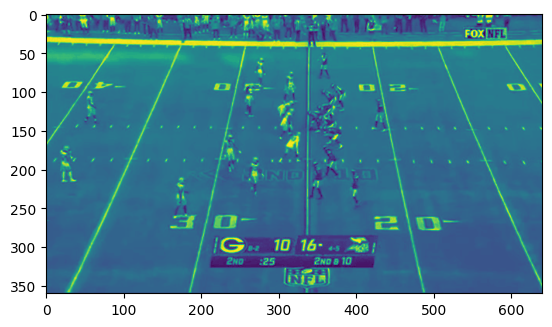

In [71]:
img_og = Image.open(test_imgs[3])
img = img_og.convert('L')
plt.imshow(img)

In [72]:
# pass img through trained model to detect field features
# lines, hashmarks, and yalrd line numbers

# lbls = model(img)

# constructed example
lbls = {
    "boxes": [
        {
            "label": "hash",
            "x": 443,
            "y": 149.5,
            "width": 18,
            "height": 7
        },
        {
            "label": "hash",
            "x": 337.5,
            "y": 187,
            "width": 17,
            "height": 8
        },
        {
            "label": "hash",
            "x": 567,
            "y": 189.5,
            "width": 18,
            "height": 9
        },
        {
            "label": "hash",
            "x": 233,
            "y": 147.5,
            "width": 16,
            "height": 9
        },
        {
            "label": "edge",
            "x": 592.5,
            "y": 40.5,
            "width": 23,
            "height": 11
        },
        {
            "label": "hash",
            "x": 549.5,
            "y": 149.5,
            "width": 17,
            "height": 7
        },
        {
            "label": "hash",
            "x": 224,
            "y": 187.5,
            "width": 16,
            "height": 9
        },
        {
            "label": "hash",
            "x": 16,
            "y": 146,
            "width": 18,
            "height": 6
        },
        {
            "label": "hash",
            "x": 126,
            "y": 146.5,
            "width": 18,
            "height": 7
        },
        {
            "label": "edge",
            "x": 174,
            "y": 40,
            "width": 22,
            "height": 12
        },
        {
            "label": "hash",
            "x": 450,
            "y": 188.5,
            "width": 18,
            "height": 7
        },
        {
            "label": "hash",
            "x": 109,
            "y": 187,
            "width": 18,
            "height": 8
        },
        {
            "label": "edge",
            "x": 257.5,
            "y": 42,
            "width": 19,
            "height": 12
        },
        {
            "label": "edge",
            "x": 421,
            "y": 42.5,
            "width": 18,
            "height": 13
        },
        {
            "label": "edge",
            "x": 505,
            "y": 41.5,
            "width": 22,
            "height": 13
        },
        {
            "label": "edge",
            "x": 87.5,
            "y": 38.5,
            "width": 21,
            "height": 13
        },
        {
            "label": "edge",
            "x": 339,
            "y": 42.5,
            "width": 20,
            "height": 13
        },
        {
            "label": "30",
            "x": 205,
            "y": 268.5,
            "width": 92,
            "height": 25
        },
        {
            "label": "20",
            "x": 466.5,
            "y": 269.5,
            "width": 91,
            "height": 23
        }
    ],
    "height": 360,
    "key": "packers_v_vikings6_0.jpg",
    "width": 640
}

new_boxes = {}
for i, bbox in enumerate(lbls["boxes"]):
    new_boxes[i] = bbox

lbls["boxes"] = new_boxes

In [73]:
def draw_lbls(img, lbls):
    draw = ImageDraw.Draw(img)

    for id, lbl in lbls["boxes"].items():
        left = int((lbl["x"] - lbl["width"]/2))
        top = int((lbl["y"] - lbl["height"]/2))
        right = int((lbl["x"] + lbl["width"]/2))
        bottom = int((lbl["y"] + lbl["height"]/2))
        draw.rectangle([left, top, right, bottom], outline="red", width=2)
        draw.text((left, bottom+10), str(lbl["label"]), fill="red")

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

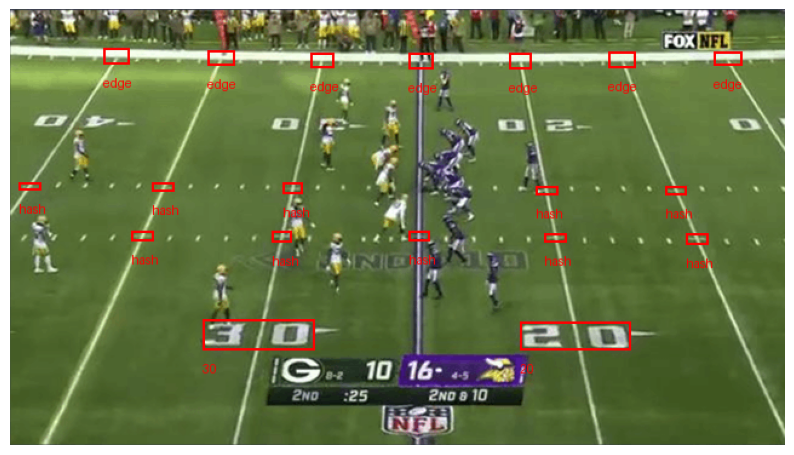

In [74]:
draw_lbls(img_og, lbls)

## Hash Lines and Side Lines Detection

In [75]:
def get_all_lines(lbls, tresh=0):
    lines = []

    for a in range(len(lbls)-1):
        i = list(lbls.keys())[a]
        for b in range(a+1, len(lbls)):
            j = list(lbls.keys())[b]
            # determine the points to use on the bbox to create a max line and min line between 2 lines

            # if 1x<2x and 1y<2y -> (BL TR) (BL TR)
            # if 1x<2x and 1y>2y -> (BR TL) (BR TL)
            # if 1x>2x and 1y<2y -> (BR TL) (BR TL)
            # if 1x>2x and 1y>2y -> (BL TR) (BL TR)

            b1 = np.array([lbls[i]["x"], lbls[i]["y"]])
            t1 = np.array([lbls[i]["x"], lbls[i]["y"]])
            w1 = lbls[i]["width"]/2
            h1 = lbls[i]["height"]/2

            b2 = np.array([lbls[j]["x"], lbls[j]["y"]])
            t2 = np.array([lbls[j]["x"], lbls[j]["y"]])
            w2 = lbls[j]["width"]/2
            h2 = lbls[j]["height"]/2

            line = {
                "points": set([i, j]),
                "count": 2
            }

            x_fac = 1 if b1[0] < b2[0] else -1
            y_fac = 1 if b1[0] < b2[0] else -1

            b1[0] -= w1*x_fac*y_fac
            t1[0] += w1*x_fac*y_fac
            b2[0] -= w2*x_fac*y_fac
            t2[0] += w2*x_fac*y_fac
            
            b1[1] += h1
            t1[1] -= h1
            b2[1] += h2
            t2[1] -= h2

            slope_top = (t2-t1)[1]/(t2-t1)[0]
            slope_bottom = (b2-b1)[1]/(b2-b1)[0]

            line["bottom"] = {
                "point": b1,
                "slope": slope_bottom
            }
            line["top"] = {
                "point": t1,
                "slope": slope_top
            }

            for c in range(len(lbls)):
                k = list(lbls.keys())[c]
                if k != i and k != j:
                    x = lbls[k]["x"]
                    y = lbls[k]["y"]

                    top_pred = slope_top*(x-t1[0])+t1[1]
                    bottom_pred = slope_bottom*(x-b1[0])+b1[1]

                    if y <= bottom_pred + tresh and y >= top_pred - tresh:
                        line["points"].add(k)
                        line["count"] += 1

                        if line["count"] == len(lbls):
                            return [line]
            
            lines.append(line)
            
    return lines

In [76]:
def get_best_combo(lines_sorted, counts, count_index, total_count, max_count, best_combo):
    count_1 = counts[count_index]

    if count_1*2 <= max_count or count_1 == 2:
        return best_combo
    
    if count_1 == total_count:
        return [lines_sorted[count_1][0], None]
    
    if best_combo is None:
        best_combo = [lines_sorted[count_1][0], None]
        max_count = count_1
    
    start_index = next(i for i, x in enumerate(counts[count_index:]) if x+count_1 <= total_count)
    if start_index is None:
        return best_combo

    for line_1 in lines_sorted[count_1]:
        for i in range(start_index, len(counts)):
            for line in lines_sorted[counts[i]]:
                if line["count"] + count_1 > max_count and line["points"].isdisjoint(line_1["points"]):
                    best_combo = [line_1, line]
                    max_count = line["count"]+ count_1

                    if max_count == total_count:
                        return best_combo
    
    if count_index+1 >= len(counts):
        return best_combo
    
    return get_best_combo(lines_sorted, counts, count_index+1, total_count, max_count, best_combo)         

In [77]:
def get_best_lines(lbls, tresh=0):
    lines = get_all_lines(lbls, tresh)
    lines_sorted = defaultdict(list)

    for line in lines:
        lines_sorted[line["count"]].append(line)
    
    counts = list(lines_sorted.keys())
    counts.sort(reverse=True)

    total_count = len(lbls)

    return get_best_combo(lines_sorted, counts, 0, total_count, 0, None)

In [78]:
edge = {id: lbl for id, lbl in lbls["boxes"].items() if lbl["label"] == "edge"}

best_sides = get_best_lines(edge, tresh=0)

print(best_sides[0]["count"], best_sides[0][ "points"])
if best_sides[1] is not None:    
    print(best_sides[1]["count"], best_sides[1][ "points"])
else:
    print(best_sides[1])

7 {4, 9, 12, 13, 14, 15, 16}
None


In [79]:
hash = {id: lbl for id, lbl in lbls["boxes"].items() if lbl["label"] == "hash"}

best_hash = get_best_lines(hash, tresh=0)

print(best_hash[0]["count"], best_hash[0][ "points"])
if best_hash[1] is not None:    
    print(best_hash[1]["count"], best_hash[1][ "points"])
else:
    print(best_hash[1])

5 {0, 3, 5, 7, 8}
5 {1, 2, 6, 10, 11}


In [80]:
print(best_hash[1])

{'points': {1, 2, 6, 10, 11}, 'count': 5, 'bottom': {'point': array([329., 191.]), 'slope': np.float64(0.013100436681222707)}, 'top': {'point': array([346., 183.]), 'slope': np.float64(0.008695652173913044)}}


## Lines Drawing

Given all points on a line, apply linear regression to find the best-fit line (wrt L2 norm)

In [81]:
def get_best_fit(ids, lbls):
    x = np.array([])
    y = np.array([])

    for id in ids:
        x = np.append(x, lbls[id]["x"])
        y = np.append(y, lbls[id]["y"])
    
    return np.polyfit(x, y, 1) 

In [82]:
def draw_lines(img, lines, lbls):
    lines_to_draw = []

    for line in lines:
        coeffs = [line["slope"], line["y0"]]
        lines_to_draw.append(coeffs)

    draw = ImageDraw.Draw(img)

    w = lbls["width"]
    h = lbls["height"]

    for line in lines_to_draw:
        slope = line[0]

        x0 = 0
        y0 = line[1]

        x1 = w
        y1 = slope*x1+y0

        if y0 < 0:
            x0 = np.ceil(-y0/slope)
            y0 = np.ceil(slope*x0+y0)
        elif y0 >= h:
            x0 = np.ceil((h-1-y0)/slope)
            y0 = np.floor(slope*x0+y0)

        if y1 < 0:
            x1 = np.floor(-y0/slope)
            y1 = np.ceil(slope*x1+y0)
        elif y1 >= h:
            x1 = np.floor((h-1-y0)/slope)
            y1 = np.floor(slope*x1+y1)

        draw.line((int(x0), int(y0), int(x1), int(y1)), fill="blue", width=2)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

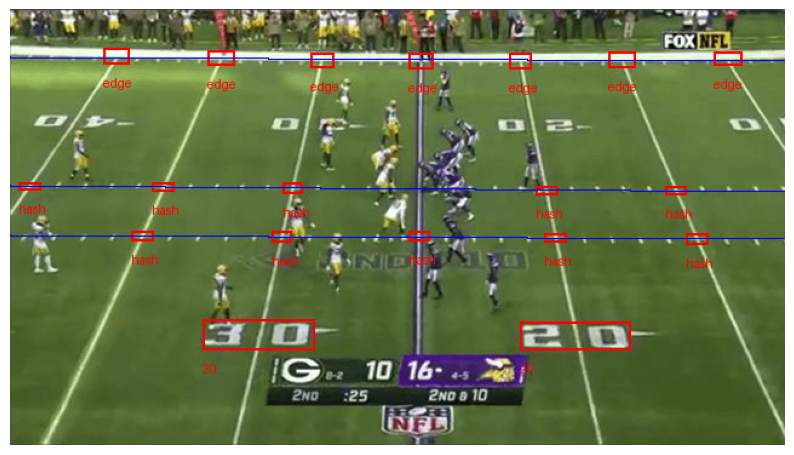

In [83]:
long_lines = []
for i in range(2):
    if best_sides[i] is not None:
        long_lines.append(best_sides[i])
    if best_hash[i] is not None:
        long_lines.append(best_hash[i])

for line in long_lines:
    coeffs = get_best_fit(line["points"], lbls["boxes"])
    line["slope"] = coeffs[0]
    line["y0"] = coeffs[1]
    
draw_lines(img_og, long_lines, lbls)

## Yard Line Detection

In [85]:
def get_yd_lines(long_lines, lbls):
    long_lines = sorted(long_lines, key=lambda x: x["count"], reverse=True)
    longest_line = long_lines[0]

    slope_perp = -1/longest_line["slope"]

    for id in longest_line["points"]: 
        pass

## Map Drawing

## Homography